In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import lightgbm as lgb
from matplotlib import pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import mlflow
import mlflow.sklearn
import mlflow.xgboost

mlflow.set_tracking_uri("http://localhost:5000")

# Explorative Data Analysis

In [54]:
# df = pd.read_excel(r'data\flats_to_rent_wue_preprocessed_combined.xlsx')
# profile = ProfileReport(df, title="Flats -  Würzburg - Rent - Overview", explorative=True)
# profile.to_file("eda-wue-rent-all.html")

In [55]:
# df = pd.read_excel(r'data\houses_to_buy_wue_preprocessed_1207.xlsx')
# profile = ProfileReport(df, title="Houses -  Würzburg - Buy - Overview", explorative=True)
# profile.to_file("eda-wue-houses.html")

# Preprocessing & Feature Engineering


In [20]:
def determineHighCorrCols(df):

    df.columns = [re.sub(r"\\u([0-9a-fA-F]{4})", lambda m: chr(int(m.group(1), 16)), col) for col in df.columns]
    df.columns = [col.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue").replace("ß", "ss") for col in df.columns]
    important_num_cols = list(df.corr()["Object_price"][(df.corr()["Object_price"]>0.20) | (df.corr()["Object_price"]<-0.20)].index)
    cat_cols = [col for col in df.columns if df[col].dtype == 'object']
    important_cols = important_num_cols + cat_cols +   ["ConstructionYear"] + ["ZipCode"]
#    df = df[important_cols]
    print(important_cols)
    return important_cols

In [4]:
def preprocess_data (df, feature_set): 
    print(f"Used feature set for preprocessing:{feature_set}")
    # renma cols to German Umlauts via Decoding
    df.columns = [re.sub(r"\\u([0-9a-fA-F]{4})", lambda m: chr(int(m.group(1), 16)), col) for col in df.columns]
    df.columns = [col.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue").replace("ß", "ss") for col in df.columns]
    
    
    df = df.replace('""', np.nan)
    df = df.dropna()
    df['LivingSpace'] = df['LivingSpace'].astype(float)
    df['Rooms'] = df['Rooms'].astype(float)
    df = df.dropna(subset=['ConstructionYear'])
    df = df.dropna(subset=['Object_price'])
    df = df.dropna(subset=['Rooms'])
    df = df.dropna(subset=['LivingSpace'])
    df['ZipCode']= df['ZipCode'].astype(str)
    df['LivingSpace']= df['LivingSpace'].astype(float)
    df = df[feature_set]
    df = df.reindex()
    df = df.reset_index(drop=True)

    # one-hot encoding
    cat_cols = [col for col in df.columns if df[col].dtype == 'object']
    y = df['Object_price']
    X = df.drop('Object_price', axis=1)
    X = pd.get_dummies(X, columns=cat_cols)

    return X, y

# Data Split


In [5]:
def data_split(X, y, train_size=0.8, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                  train_size=train_size, 
                                                  random_state = random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  train_size=train_size, 
                                                  random_state = random_state)
    return X_train, y_train, X_val, y_val, X_test, y_test

# Training, Evaluation and Logging Of Models

## Baseline 

In [6]:
def scrape_avg_rental_prices():
    url = "https://www.wohnungsboerse.net/mietspiegel-Wuerzburg/2772"
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    script_tag = soup.find("script", string=lambda text: "pdfData" in text)
    rental_price = 0
    if script_tag:
        script_content = script_tag.string
        start_index = script_content.find("avg_rent_price: ") + len("avg_rent_price: '")
        end_index = script_content.find("',", start_index)
        rental_price = script_content[start_index:end_index]
        rental_price = (
            rental_price.replace("€/m2", "").replace(".", "").replace(",", ".")
        )
        rental_price = rental_price.strip()
        rental_price = float(rental_price)
        print(f"Extrcated rental price per square meter via scraper: {rental_price}")
    else:
        print("The script tag containing the rental price was not found.")
    return rental_price

In [7]:
def scrape_avg_buy_prices():
    url = "https://www.wohnungsboerse.net/immobilienpreise-Wuerzburg/2772"
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    p_element = soup.find("p", class_="mb-8")
    buy_price = 0
    if p_element:
        pattern = r"\d{1,3}(?:\.\d{3})*(?:,\d{2})?€/m²"
        match = re.search(pattern, p_element.text)
        if match:
            buy_price = match.group()
            buy_price = buy_price.replace("€/m²", "").replace(".", "").replace(",", ".")
            print(f"Extrcated buy price per square meter via scraper: {buy_price}")
        else:
            print("Price not found")
    else:
        print("The element ontaining the buy price was not found.")
    return buy_price

In [8]:
def baseline_rent(val_X, val_y, runname="baseline_rent"):
    avg_price_per_sqm_rent = scrape_avg_rental_prices()
    print(f"Average rental price per sqm: {avg_price_per_sqm_rent}")
    baseline_preds = val_X['LivingSpace'] * avg_price_per_sqm_rent
    baseline_mae = mean_absolute_error(val_y, baseline_preds)
    baseline_r2 = r2_score(val_y, baseline_preds)
    baseline_mse = mean_squared_error(val_y, baseline_preds)

    with mlflow.start_run(run_name=runname):
        mlflow.log_metric("mse", baseline_mse)
        mlflow.log_metric("mae", baseline_mae)
        mlflow.log_metric("r2", baseline_r2)

    print(f"Baseline Mae: {baseline_mae}")
    print(f"Baseline MSE: {baseline_mse}")    
    print(f"Baseline R2 Score: {baseline_r2}")
    return avg_price_per_sqm_rent, baseline_mae, baseline_mse, baseline_r2

In [9]:
def baseline_buy(X_val, y_val, runname="baseline_buy"):
    avg_price_per_sqm_buy = scrape_avg_buy_prices()
    print(f"Average rental price per sqm: {avg_price_per_sqm_buy}")
    
    baseline_preds = X_val['LivingSpace'] * avg_price_per_sqm_buy
    baseline_mae = mean_absolute_error(y_val, baseline_preds)
    baseline_r2 = r2_score(y_val, baseline_preds)
    baseline_mse = mean_squared_error(y_val, baseline_preds)

    with mlflow.start_run(run_name=runname):
        mlflow.log_metric("mse", baseline_mse)
        mlflow.log_metric("mae", baseline_mae)
        mlflow.log_metric("r2", baseline_r2)

    print(f"Baseline Mae: {baseline_mae}")
    print(f"Baseline MSE: {baseline_mse}")    
    print(f"Baseline R2 Score: {baseline_r2}")

    return avg_price_per_sqm_buy, baseline_mae, baseline_mse, baseline_r2

## Linear Regression

In [10]:
def train_and_eval_linear(X_train, y_train, X_val, y_val, runname ="linear-regression"):
    mlflow.sklearn.autolog()
    with mlflow.start_run(run_name=runname):
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        pred_train = model.predict(X_train)
        mae_train = mean_absolute_error(y_train, pred_train)
        mse_train = mean_squared_error(y_train, pred_train)
        r2_train = r2_score(y_train, pred_train)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("r2_train", r2_train)
        
        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        mlflow.log_metric("mae", mae_train)
        mlflow.log_metric("mse", mse_train)
        mlflow.log_metric("r2", r2_train)
    return model, mae, mse, r2, mae_train, mse_train, r2_train

## Lasso Regression

In [11]:
def train_and_eval_lasso(X_train, y_train, X_val, y_val, runname ="lasso-regression"):
    mlflow.sklearn.autolog()
    with mlflow.start_run(run_name=runname):
        model = Lasso()
        model.fit(X_train, y_train)
        
        pred_train = model.predict(X_train)
        mae_train = mean_absolute_error(y_train, pred_train)
        mse_train = mean_squared_error(y_train, pred_train)
        r2_train = r2_score(y_train, pred_train)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("r2_train", r2_train)
        
        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        mlflow.log_metric("mae", mae_train)
        mlflow.log_metric("mse", mse_train)
        mlflow.log_metric("r2", r2_train)
    return model, mae, mse, r2, mae_train, mse_train, r2_train

## Ridge Regression

In [12]:
def train_and_eval_ridge(X_train, y_train, X_val, y_val, runname ="ridge-regression"):
    mlflow.sklearn.autolog()
    with mlflow.start_run(run_name=runname):
        model = Ridge()
        model.fit(X_train, y_train)
        
        pred_train = model.predict(X_train)
        mae_train = mean_absolute_error(y_train, pred_train)
        mse_train = mean_squared_error(y_train, pred_train)
        r2_train = r2_score(y_train, pred_train)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("r2_train", r2_train)
        
        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        mlflow.log_metric("mae", mae_train)
        mlflow.log_metric("mse", mse_train)
        mlflow.log_metric("r2", r2_train)
    return model, mae, mse, r2, mae_train, mse_train, r2_train

## Random Forest

In [13]:
def train_and_eval_rf(X_train, y_train, X_val, y_val, n_estimators=50, random_state=0, run_name="random-forest"):
    mlflow.sklearn.autolog()
    with mlflow.start_run(run_name=run_name):
        model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        mae_train = mean_absolute_error(y_train, pred_train)
        mse_train = mean_squared_error(y_train, pred_train)
        r2_train = r2_score(y_train, pred_train)
        preds= model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mse = mean_squared_error(y_val, preds)
        r2 = r2_score(y_val, preds)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("r2_train", r2_train)
        return model, mae, mse, r2, mae_train, mse_train, r2_train

## XGBRegressor


In [14]:
def train_and_eval_xgb(X_train, y_train, X_val, y_val, run_name="xgb", early_stopping_rounds=30, max_depth=6, n_estimators=1000):
    mlflow.xgboost.autolog()
    with mlflow.start_run(run_name=run_name):
        model = xgb.XGBRegressor(eval_metric=['rmse', 'mae'], early_stopping_rounds=early_stopping_rounds, random_state=42, max_depth=max_depth, n_estimators=n_estimators)
        mlflow.log_param("early_stopping_rounds", early_stopping_rounds)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("n_estimators", n_estimators)
        model.fit(X=X_train, 
                  y=y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=True
        )
        pred_train = model.predict(X_train)
        mae_train = mean_absolute_error(y_train, pred_train)
        mse_train = mean_squared_error(y_train, pred_train)
        r2_train = r2_score(y_train, pred_train)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("r2_train", r2_train)
        preds= model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mse = mean_squared_error(y_val, preds)
        r2 = r2_score(y_val, preds)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("r2", r2)        
        return model, mae, mse, r2, mae_train, mse_train, r2_train

## ElasticNet

In [15]:
def train_and_eval_elasticnet(X_train, y_train, X_val, y_val, runname="elasticNet"):
    mlflow.sklearn.autolog()
    with mlflow.start_run(run_name=runname):
        model = ElasticNet()
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        mae_train = mean_absolute_error(y_train, pred_train)
        mse_train = mean_squared_error(y_train, pred_train)
        r2_train = r2_score(y_train, pred_train)
        preds= model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mse = mean_squared_error(y_val, preds)
        r2 = r2_score(y_val, preds)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("r2_train", r2_train)
        return model, mae, mse, r2, mae_train, mse_train, r2_train

# Complete Pipeline

In [16]:
def pipeline_from_extracted(df, feature_set, model_name="lasso"):
    
    X, y = preprocess_data(df, feature_set)
    print("Done with preprocessing")
    X_train, y_train, X_val, y_val, test_X, test_y = data_split(X,y)
    print("Done with data split")

    model, mae, mse, r2, mae_train, mse_train, r2_train = None, None, None, None, None, None, None

    if model_name == "lasso":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_lasso(X_train, y_train, X_val, y_val)
    elif model_name == "ridge":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_ridge(X_train, y_train, X_val, y_val)
    elif model_name == "rf":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_rf(X_train, y_train, X_val, y_val)
    elif model_name == "xgb":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_xgb(X_train, y_train, X_val, y_val)
    elif model_name == "elasticnet":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_elasticnet(X_train, y_train, X_val, y_val)
    elif model_name == "linear":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_linear(X_train, y_train, X_val, y_val)
    elif model_name =="baseline-rent":
        avg_price, mae, mse, r2 = baseline_rent(X_val, y_val)
    else:
        print("Model not found. Model_name must be 'lasso', 'ridge', 'rf', 'xgb', 'elasticnet', 'linear', 'baseline_buy' or 'baseline_rent'")
    print("Done with train")
    return model, mae, mse, r2, mae_train, mse_train, r2_train

# Execute all models on same data and log to MLFlow

In [19]:
df = pd.read_excel(r'data\flats_to_rent_wue_preprocessed_combined.xlsx')
feature_set_high_corr = determineHighCorrCols(df) + ["ConstructionYear"] + ["ZipCode"]
print(feature_set_high_corr)
feature_set_selected = [
    "Object_price",
    "ConstructionYear",
    "LivingSpace",
    "ZipCode",
    "Rooms",
    "altbau_(bis_1945)",
    "balkon",
    "barriefrei",
    "dachgeschoss",
    "erstbezug",
    "einbaukueche",
    "fliesen",
    "neubau",
    "parkett",
    "stellplatz",
    "wg_geeignet",
    "bad/wc_getrennt",
    "kamin",
    "personenaufzug",
    "garten", 
    "garage", 
    "moebliert", 
    "renoviert", 
    "terrasse",
    "wanne", 
    "zentralheizung"
]

['Object_price', 'LivingSpace', 'Rooms', 'abstellraum', 'bad/wc_getrennt', 'barriefrei', 'dusche', 'elektro', 'erdwaerme', 'fenster', 'ferne', 'fliesen', 'frei', 'fussbodenheizung', 'gaestewc', 'garage', 'kable_sat_tv', 'kontrollierte_be-_und_entlueftungsanlage', 'kunststofffenster', 'luftwp', 'parkett', 'personenaufzug', 'reinigung', 'rollstuhlgerecht', 'speisekammer', 'terrasse', 'wanne', 'zentralheizung', 'EstateType', 'DistributionType']
['Object_price', 'LivingSpace', 'Rooms', 'abstellraum', 'bad/wc_getrennt', 'barriefrei', 'dusche', 'elektro', 'erdwaerme', 'fenster', 'ferne', 'fliesen', 'frei', 'fussbodenheizung', 'gaestewc', 'garage', 'kable_sat_tv', 'kontrollierte_be-_und_entlueftungsanlage', 'kunststofffenster', 'luftwp', 'parkett', 'personenaufzug', 'reinigung', 'rollstuhlgerecht', 'speisekammer', 'terrasse', 'wanne', 'zentralheizung', 'EstateType', 'DistributionType', 'ConstructionYear', 'ZipCode']


C:\Users\michi\AppData\Local\Temp\ipykernel_8100\2452901690.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  important_num_cols = list(df.corr()["Object_price"][(df.corr()["Object_price"]>0.20) | (df.corr()["Object_price"]<-0.20)].index)


In [21]:
model_names = ['lasso', 'ridge', 'rf', 'xgb', 'elasticnet', 'linear', 'baseline-rent']
mlflow.set_experiment("wue-rent-high-corr-features-comparison")

df = pd.read_excel(r'data\flats_to_rent_wue_preprocessed_combined.xlsx')
feature_set_high_corr = determineHighCorrCols(df)
    
for model_name in model_names:
    df = pd.read_excel(r'data\flats_to_rent_wue_preprocessed_combined.xlsx')
    print("Starting with model: ", model_name)
    pipeline_from_extracted(df, model_name=model_name, feature_set=feature_set_high_corr)
    print("Done with model: ", model_name)
    print("--------------------------------------------------")


C:\Users\michi\AppData\Local\Temp\ipykernel_8100\4053851449.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  important_num_cols = list(df.corr()["Object_price"][(df.corr()["Object_price"]>0.20) | (df.corr()["Object_price"]<-0.20)].index)


['Object_price', 'LivingSpace', 'Rooms', 'abstellraum', 'bad/wc_getrennt', 'barriefrei', 'dusche', 'elektro', 'erdwaerme', 'fenster', 'ferne', 'fliesen', 'frei', 'fussbodenheizung', 'gaestewc', 'garage', 'kable_sat_tv', 'kontrollierte_be-_und_entlueftungsanlage', 'kunststofffenster', 'luftwp', 'parkett', 'personenaufzug', 'reinigung', 'rollstuhlgerecht', 'speisekammer', 'terrasse', 'wanne', 'zentralheizung', 'EstateType', 'DistributionType', 'ConstructionYear', 'ZipCode']
Done
Index(['Unnamed: 0', 'Object_price', 'LivingSpace', 'Rooms',
       'ConstructionYear', 'ZipCode', 'EstateType', 'DistributionType',
       'abstellraum', 'als_ferienimmobilie_geeignet', 'altbau_(bis_1945)',
       'bad/wc_getrennt', 'balkon', 'barriefrei', 'bidet', 'carport',
       'dachgeschoss', 'dielen', 'dsl', 'duplex', 'dusche', 'einbauk\u00fcche',
       'elektro', 'erdgeschoss', 'erdwaerme', 'erstbezug', 'estrich',
       'etagenheizung', 'fenster', 'fern', 'ferne', 'fliesen', 'frei',
       'fu\u00dfbod

2023/07/12 17:32:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\enterpriseai2\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/07/12 17:32:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\env

Done with train
Index(['Unnamed: 0', 'Object_price', 'LivingSpace', 'Rooms',
       'ConstructionYear', 'ZipCode', 'EstateType', 'DistributionType',
       'abstellraum', 'als_ferienimmobilie_geeignet', 'altbau_(bis_1945)',
       'bad/wc_getrennt', 'balkon', 'barriefrei', 'bidet', 'carport',
       'dachgeschoss', 'dielen', 'dsl', 'duplex', 'dusche', 'einbauk\u00fcche',
       'elektro', 'erdgeschoss', 'erdwaerme', 'erstbezug', 'estrich',
       'etagenheizung', 'fenster', 'fern', 'ferne', 'fliesen', 'frei',
       'fu\u00dfbodenheizung', 'gaestewc', 'garage', 'garten', 'gartennutzung',
       'gas', 'gepflegt', 'haustiere_erlaubt', 'holzfenster', 'kable_sat_tv',
       'kamera', 'kamin', 'kelleranteil', 'kfw40', 'kfw55', 'klimatisiert',
       'kontrollierte_be-_und_entl\u00fcftungsanlage', 'kunststoff',
       'kunststofffenster', 'laminat', 'linoleum', 'loggia', 'luftwp',
       'marmor', 'massivhaus', 'moebliert', 'neubau', 'neuwertig', 'oel',
       'ofenheizung', 'offene_k\u00fc

2023/07/12 17:33:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\enterpriseai2\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/07/12 17:33:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\env

Done with train
Index(['Unnamed: 0', 'Object_price', 'LivingSpace', 'Rooms',
       'ConstructionYear', 'ZipCode', 'EstateType', 'DistributionType',
       'abstellraum', 'als_ferienimmobilie_geeignet', 'altbau_(bis_1945)',
       'bad/wc_getrennt', 'balkon', 'barriefrei', 'bidet', 'carport',
       'dachgeschoss', 'dielen', 'dsl', 'duplex', 'dusche', 'einbauk\u00fcche',
       'elektro', 'erdgeschoss', 'erdwaerme', 'erstbezug', 'estrich',
       'etagenheizung', 'fenster', 'fern', 'ferne', 'fliesen', 'frei',
       'fu\u00dfbodenheizung', 'gaestewc', 'garage', 'garten', 'gartennutzung',
       'gas', 'gepflegt', 'haustiere_erlaubt', 'holzfenster', 'kable_sat_tv',
       'kamera', 'kamin', 'kelleranteil', 'kfw40', 'kfw55', 'klimatisiert',
       'kontrollierte_be-_und_entl\u00fcftungsanlage', 'kunststoff',
       'kunststofffenster', 'laminat', 'linoleum', 'loggia', 'luftwp',
       'marmor', 'massivhaus', 'moebliert', 'neubau', 'neuwertig', 'oel',
       'ofenheizung', 'offene_k\u00fc

2023/07/12 17:33:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\enterpriseai2\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/07/12 17:33:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\env

Done with train
Index(['Unnamed: 0', 'Object_price', 'LivingSpace', 'Rooms',
       'ConstructionYear', 'ZipCode', 'EstateType', 'DistributionType',
       'abstellraum', 'als_ferienimmobilie_geeignet', 'altbau_(bis_1945)',
       'bad/wc_getrennt', 'balkon', 'barriefrei', 'bidet', 'carport',
       'dachgeschoss', 'dielen', 'dsl', 'duplex', 'dusche', 'einbauk\u00fcche',
       'elektro', 'erdgeschoss', 'erdwaerme', 'erstbezug', 'estrich',
       'etagenheizung', 'fenster', 'fern', 'ferne', 'fliesen', 'frei',
       'fu\u00dfbodenheizung', 'gaestewc', 'garage', 'garten', 'gartennutzung',
       'gas', 'gepflegt', 'haustiere_erlaubt', 'holzfenster', 'kable_sat_tv',
       'kamera', 'kamin', 'kelleranteil', 'kfw40', 'kfw55', 'klimatisiert',
       'kontrollierte_be-_und_entl\u00fcftungsanlage', 'kunststoff',
       'kunststofffenster', 'laminat', 'linoleum', 'loggia', 'luftwp',
       'marmor', 'massivhaus', 'moebliert', 'neubau', 'neuwertig', 'oel',
       'ofenheizung', 'offene_k\u00fc

2023/07/12 17:34:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\enterpriseai2\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/07/12 17:35:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\e

Done with train
Index(['Unnamed: 0', 'Object_price', 'LivingSpace', 'Rooms',
       'ConstructionYear', 'ZipCode', 'EstateType', 'DistributionType',
       'abstellraum', 'als_ferienimmobilie_geeignet', 'altbau_(bis_1945)',
       'bad/wc_getrennt', 'balkon', 'barriefrei', 'bidet', 'carport',
       'dachgeschoss', 'dielen', 'dsl', 'duplex', 'dusche', 'einbauk\u00fcche',
       'elektro', 'erdgeschoss', 'erdwaerme', 'erstbezug', 'estrich',
       'etagenheizung', 'fenster', 'fern', 'ferne', 'fliesen', 'frei',
       'fu\u00dfbodenheizung', 'gaestewc', 'garage', 'garten', 'gartennutzung',
       'gas', 'gepflegt', 'haustiere_erlaubt', 'holzfenster', 'kable_sat_tv',
       'kamera', 'kamin', 'kelleranteil', 'kfw40', 'kfw55', 'klimatisiert',
       'kontrollierte_be-_und_entl\u00fcftungsanlage', 'kunststoff',
       'kunststofffenster', 'laminat', 'linoleum', 'loggia', 'luftwp',
       'marmor', 'massivhaus', 'moebliert', 'neubau', 'neuwertig', 'oel',
       'ofenheizung', 'offene_k\u00fc

2023/07/12 17:35:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\enterpriseai2\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/07/12 17:35:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\env

Done with train
Index(['Unnamed: 0', 'Object_price', 'LivingSpace', 'Rooms',
       'ConstructionYear', 'ZipCode', 'EstateType', 'DistributionType',
       'abstellraum', 'als_ferienimmobilie_geeignet', 'altbau_(bis_1945)',
       'bad/wc_getrennt', 'balkon', 'barriefrei', 'bidet', 'carport',
       'dachgeschoss', 'dielen', 'dsl', 'duplex', 'dusche', 'einbauk\u00fcche',
       'elektro', 'erdgeschoss', 'erdwaerme', 'erstbezug', 'estrich',
       'etagenheizung', 'fenster', 'fern', 'ferne', 'fliesen', 'frei',
       'fu\u00dfbodenheizung', 'gaestewc', 'garage', 'garten', 'gartennutzung',
       'gas', 'gepflegt', 'haustiere_erlaubt', 'holzfenster', 'kable_sat_tv',
       'kamera', 'kamin', 'kelleranteil', 'kfw40', 'kfw55', 'klimatisiert',
       'kontrollierte_be-_und_entl\u00fcftungsanlage', 'kunststoff',
       'kunststofffenster', 'laminat', 'linoleum', 'loggia', 'luftwp',
       'marmor', 'massivhaus', 'moebliert', 'neubau', 'neuwertig', 'oel',
       'ofenheizung', 'offene_k\u00fc

2023/07/12 17:36:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\enterpriseai2\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/07/12 17:36:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\env

Done with train
Index(['Unnamed: 0', 'Object_price', 'LivingSpace', 'Rooms',
       'ConstructionYear', 'ZipCode', 'EstateType', 'DistributionType',
       'abstellraum', 'als_ferienimmobilie_geeignet', 'altbau_(bis_1945)',
       'bad/wc_getrennt', 'balkon', 'barriefrei', 'bidet', 'carport',
       'dachgeschoss', 'dielen', 'dsl', 'duplex', 'dusche', 'einbauk\u00fcche',
       'elektro', 'erdgeschoss', 'erdwaerme', 'erstbezug', 'estrich',
       'etagenheizung', 'fenster', 'fern', 'ferne', 'fliesen', 'frei',
       'fu\u00dfbodenheizung', 'gaestewc', 'garage', 'garten', 'gartennutzung',
       'gas', 'gepflegt', 'haustiere_erlaubt', 'holzfenster', 'kable_sat_tv',
       'kamera', 'kamin', 'kelleranteil', 'kfw40', 'kfw55', 'klimatisiert',
       'kontrollierte_be-_und_entl\u00fcftungsanlage', 'kunststoff',
       'kunststofffenster', 'laminat', 'linoleum', 'loggia', 'luftwp',
       'marmor', 'massivhaus', 'moebliert', 'neubau', 'neuwertig', 'oel',
       'ofenheizung', 'offene_k\u00fc

## Visual Representation Of Results

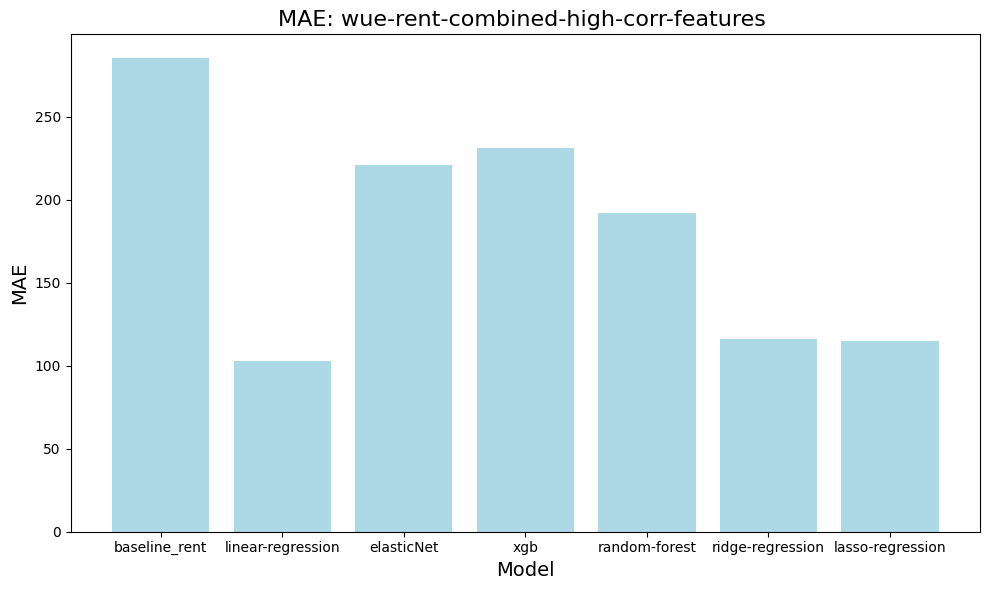

In [38]:
mlflow.search_runs(experiment_names=["wue-rent-high-corr-features-comparison"])
runs = mlflow.search_runs(experiment_names=["wue-rent-high-corr-features-comparison"])
mae_runs = runs[runs["metrics.mae"].notnull()]
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(mae_runs["tags.mlflow.runName"], mae_runs["metrics.mae"], color='lightblue')
ax.set_xlabel("Model", fontsize=14)
ax.set_ylabel("MAE", fontsize=14)
ax.set_title("MAE: wue-rent-combined-high-corr-features", fontsize=16)
plt.tight_layout()
plt.show()